This is the code to perform PCA on input feature map
===
Please setup a similar environment in case you want ot run this code on your machine.   

- __Software Environment__:  
    Anaconda 3.6  
    matplotlib  
    sklearn  
    numpy  
    pytorch 1.0  
    cupy  
    
- __Hardware Environment__:  
    32 cores Intel Xeon E5 CPU  
    64 GB RAM  
    2 TB SSD  
    Dual Nvidia Tesla V100 GPU (16 GB RAM each)  
- __Training Parameter__:  
    network: DNN with one square matrix hidden layer  
    starting learning rate: 1e-2  
    learning rate decay: uniform 3 stages, each stage multiply by 0.1  
    epoch: 150  
    optimizer: SGD  

In [5]:
from nn_forward import MLP
from input_pca import *
import torch
torch.set_printoptions(profile="short")  # or 'default'

from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

from cuml import umap

import matplotlib.pyplot as plt

import numpy as np
np.set_printoptions(suppress=True, linewidth=np.nan, precision=2, threshold=1000000)

import cupy as cp
cp.cuda.Device(1).use()

ImportError: libcublas.so.9.2: cannot open shared object file: No such file or directory

Load DNN model and MNIST Dataset
---

In [7]:
# get the train, test set in matrix
# Mlp = MLP(model_loc="./model/model_reduced_64", in_size=91, hid_size=64)
Mlp = MLP(model_loc="./model/model_original_64", in_size=28*28, hid_size=64)
mnist_train_data, mnist_train_label, mnist_test_data, mnist_test_label = Mlp.get_data_matrix()

trainset matrix/label shape (60000, 784) (60000,)
testset matrix/label shape (10000, 784) (10000,)


MP Distribution Demo
---

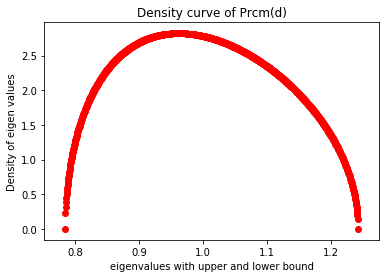

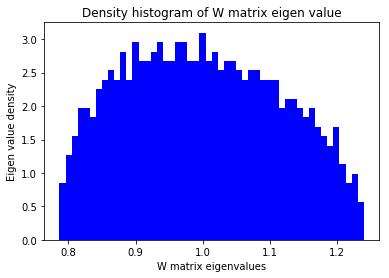

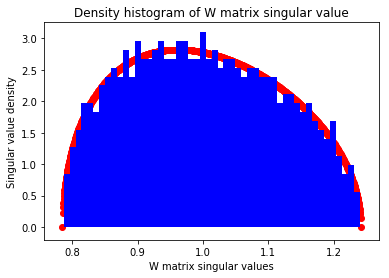

In [3]:
# compute empirical eigen density of Guassian noise matrix
m, n = mnist_train_data.shape
d, Prcm = compute_mp_dist(m, n)
vt_w, s_w, u_w = compute_eigen_iid(m, n, solver='svd')

# show curve
plt.hist(s_w.get(), bins=50, color='b', density=True)
plt.scatter(d, Prcm, color='r')
plt.title("Density histogram of W matrix singular value")
plt.xlabel('Singular values of W')
plt.ylabel('Singular value density')
plt.show()

Correlation Matrix Analysis
---

In [4]:
# compute covariance matrix
data_gpu = cp.asarray(mnist_train_data)
data_cov = (1/mnist_train_data.shape[0])*(data_gpu.T.dot(data_gpu))

# get diagonal matrix of data_cov
data_diag_half = cp.nan_to_num(cp.diag(data_cov)**(-1/2))
data_diag_half = cp.diag(data_diag_half)

# compute correlation matrix
data_corr = cp.dot(data_diag_half.dot(data_cov), data_diag_half)

# compute the singular value of correlation matrix
u, s, vt = np.linalg.svd(data_corr.get())

# recommand reserved value
recommand_dim = len(s[s>1.7])

There're 91 number of singular value out of MP distribution


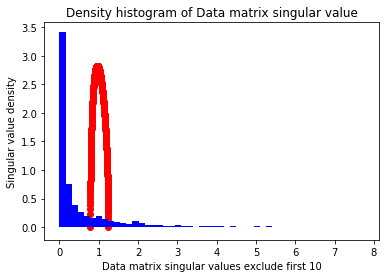

In [5]:
print("There're {} number of singular value out of MP distribution".format(recommand_dim))
plt.hist(s[10:], bins=50, color='b', density=True)
plt.scatter(d, Prcm, color='r')
plt.title("Density histogram of Data matrix singular value")
plt.xlabel('Data matrix singular values exclude first 10')
plt.ylabel('Singular value density')
plt.show()

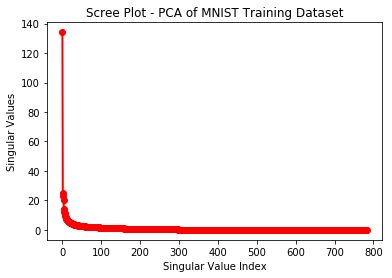

In [6]:
plt.plot(np.arange(s.shape[0]), s, 'ro-', linewidth=2)
plt.title("Scree Plot - PCA of MNIST Training Dataset")
plt.xlabel('Singular Value Index')
plt.ylabel('Singular Values')
plt.show()

Perform PCA
---

In [8]:
recommand_dim=91

In [9]:
pca = PCA(recommand_dim)
train_data_reduced = pca.fit_transform(mnist_train_data)
%time test_data_reduced = pca.transform(mnist_test_data)
data_singular = pca.singular_values_
data_explained_ratio = sum(pca.explained_variance_ratio_)

CPU times: user 153 ms, sys: 0 ns, total: 153 ms
Wall time: 19.5 ms


In [10]:
print("{} dimension has been reserved".format(recommand_dim))
print("explained ratio is {}".format(data_explained_ratio))

91 dimension has been reserved
explained ratio is 0.9045795213896781


Perform Training
---

In [9]:
model = Mlp.init_model
Mlp.test(model)


Test set: Average loss: 0.0817, Accuracy: 9814/10000 (98%)



In [20]:
new_model = Mlp.train(train_data_reduced, mnist_train_label, 
                      test_data_reduced, mnist_test_label,
                      in_size=recommand_dim, hid_size=16)

Train Epoch: 1 	 Loss: 0.104399

Test set: Average loss: 0.3266, Accuracy: 8991/10000 (90%)

Train Epoch: 2 	 Loss: 0.033889

Test set: Average loss: 0.2472, Accuracy: 9258/10000 (93%)

Train Epoch: 3 	 Loss: 0.022390

Test set: Average loss: 0.2191, Accuracy: 9347/10000 (93%)

Train Epoch: 4 	 Loss: 0.019448

Test set: Average loss: 0.2028, Accuracy: 9376/10000 (94%)

Train Epoch: 5 	 Loss: 0.017750

Test set: Average loss: 0.1906, Accuracy: 9422/10000 (94%)

Train Epoch: 6 	 Loss: 0.016452

Test set: Average loss: 0.1819, Accuracy: 9453/10000 (95%)

Train Epoch: 7 	 Loss: 0.014461

Test set: Average loss: 0.1747, Accuracy: 9473/10000 (95%)

Train Epoch: 8 	 Loss: 0.013671

Test set: Average loss: 0.1693, Accuracy: 9483/10000 (95%)

Train Epoch: 9 	 Loss: 0.014083

Test set: Average loss: 0.1653, Accuracy: 9498/10000 (95%)

Train Epoch: 10 	 Loss: 0.013425

Test set: Average loss: 0.1624, Accuracy: 9512/10000 (95%)

Train Epoch: 11 	 Loss: 0.012640

Test set: Average loss: 0.1598, Acc

Train Epoch: 89 	 Loss: 0.014982

Test set: Average loss: 0.1410, Accuracy: 9585/10000 (96%)

Train Epoch: 90 	 Loss: 0.015002

Test set: Average loss: 0.1410, Accuracy: 9585/10000 (96%)

Train Epoch: 91 	 Loss: 0.014977

Test set: Average loss: 0.1410, Accuracy: 9584/10000 (96%)

Train Epoch: 92 	 Loss: 0.014860

Test set: Average loss: 0.1410, Accuracy: 9585/10000 (96%)

Train Epoch: 93 	 Loss: 0.014933

Test set: Average loss: 0.1410, Accuracy: 9586/10000 (96%)

Train Epoch: 94 	 Loss: 0.014916

Test set: Average loss: 0.1410, Accuracy: 9587/10000 (96%)

Train Epoch: 95 	 Loss: 0.014773

Test set: Average loss: 0.1410, Accuracy: 9587/10000 (96%)

Train Epoch: 96 	 Loss: 0.014808

Test set: Average loss: 0.1410, Accuracy: 9587/10000 (96%)

Train Epoch: 97 	 Loss: 0.014743

Test set: Average loss: 0.1410, Accuracy: 9587/10000 (96%)

Train Epoch: 98 	 Loss: 0.014727

Test set: Average loss: 0.1410, Accuracy: 9588/10000 (96%)

Train Epoch: 99 	 Loss: 0.014665

Test set: Average loss: 0.

In [13]:
# %time Mlp.spead_test(Mlp.init_model, test_data_reduced, mnist_test_label)
%time Mlp.spead_test(Mlp.init_model, mnist_test_data, mnist_test_label)


Test set: Average loss: 0.1071, Accuracy: 9765/10000 (98%)

CPU times: user 9.28 ms, sys: 14 µs, total: 9.29 ms
Wall time: 7.95 ms
